# Model Comparison
By: Griffin Hosseinzadeh (2025 May 7)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

We'll start by generating some synthetic data from a slightly more complicated model than usual. The true underlying model will be a straight line plus a sinusoid. Imagine, for example, that these data are measurements of the brightness of a variable star over time. It could have short-timescale oscillations in brightness while also increasing in average brightness over the long term. Let's model this as
$$ y_3(x) = m x + b + a\sin(2\pi x) $$
where the three model parameters are the slope $m$, the intercept $b$, and the amplitude of the oscillations $a$.
We're going to compare this model with a simpler model without the oscillations:
$$ y_2(x) = m x + b $$
When we have noisy data, we may not be able to tell the difference between these two models.

First, write both these models down as function. We will want to call them later on.

In [10]:
def model3(x, m, b, a):
    y3 = m*x + b + a*np.sin(2*np.pi*x)
    return y3

def model2(x, m, b):
    y2 = m*x + b
    return y2

Generate 100 random points in the range $0<x<1$ and evaulate the true model ($y_3$) at these points given the parameters below. Then add Gaussian noise to each point using the value of $\sigma$ below. Plot your synthetic data set (with error bars) and visually compare it with your two proposed models.

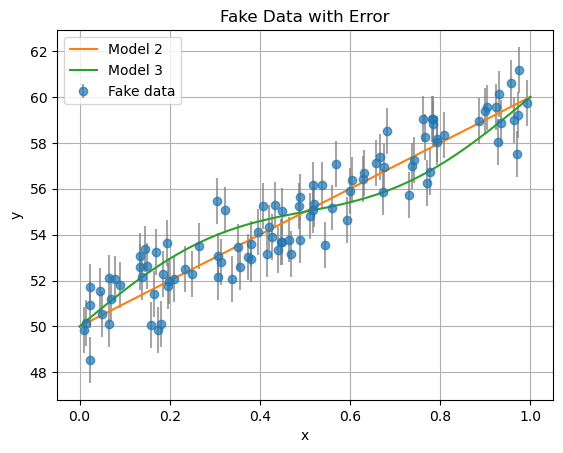

In [43]:
N = 100       # number of points
m_true = 10.  # slope
b_true = 50.  # intercept
a_true = 1.   # amplitude
sigma = 1.    # scatter

rng = np.random.default_rng(seed=13579)
x = rng.uniform(0,1,N)
y_noise_free = model3(x, m_true, b_true, a_true)
y = m_true * x + b_true + rng.normal(0, sigma, N)
dy = np.full(N, sigma)

x_model = np.linspace(0, 1, 100)
y_model2 = model2(x_model, m_true, b_true)
y_model3 = model3(x_model, m_true, b_true, a_true)

plt.errorbar(x, y, dy, fmt='o', label='Fake data', ecolor='gray', alpha=0.7)
#plt.plot(x, y_noise_free)
plt.plot(x_model, y_model2, label = 'Model 2')
plt.plot(x_model, y_model3, label = 'Model 3')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Fake Data with Error")
plt.legend()
plt.grid(True)
plt.show()

From now on, we are pretending we don't know which model is true, or what the true values of the parameters are. We have a data set, and we want to figure out which model is a a better fit, and whether it is significantly better or not, given the different numbers of parameters.

For each model, write down functions for the logarithm of the prior, likelihood, and posterior. **Make sure your prior is properly normalized.** Use these functions to calculate the Bayesian evidence for each model. This is very similar to what we did in the Bayesian statistics exercise, with one additional step: numerical integration (`np.trapezoid`) of the entire posterior grid.

In [59]:
m_min = 0.5  # technically cannot be =0 for a log-uniform prior
m_max = 99.5
b_min = 0.5
b_max = 99.5


def log_prior2(theta):
    m, b = theta
    if m_min <= m <= m_max and b_min <= b <= b_max:
        norm = (m_max - m_min) * (b_max - b_min)
        return -np.log(norm)  # normalization
    else:
        return -np.inf
        
def log_likelihood2(theta, x, y, dy):
    m, b = theta
    y_model2 = model2(x, m, b)
    chisqr = np.sum(((y - y_model2) / dy) ** 2)
    logL2 = -0.5 * chisqr - np.sum(np.log(dy)) - 0.5 * len(x) * np.log(2 * np.pi)
    return logL2

def log_posterior2(theta, x, y, dy):
    lp = log_prior2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood2(theta, x, y, dy)
    
m_range2 = np.linspace(m_min, m_max, 100)
b_range2 = np.linspace(b_min, b_max, 100)
theta2 = np.array(np.meshgrid(m_range2, b_range2))
m_grid, b_grid = np.meshgrid(m_vals, b_vals, indexing='ij')  # shape (100, 100)
theta2 = np.column_stack([m_grid.ravel(), b_grid.ravel()])   # shape (10000, 2)

posterior_grid2 = np.array([np.exp(log_posterior2(t, x, y, dy)) for t in theta2])

evidence2 = np.trapezoid(np.trapezoid(posterior_grid2, b_range2, axis=1),m_range2)

print(evidence2)

ValueError: too many values to unpack (expected 2)

In [ ]:
a_min = 0.1
a_max = 10.

def log_prior3(theta):
    m, b = theta # parameter vector 
    if m_min < m < m_max and b_min < b < b_max: # defining my Prior function based on the equation above
        ln_prior3 = 0.0  # log(1), uniform prior within allowed range
    else:
        ln_prior3 = -np.inf  # log(0), invalid values
    return ln_prior3

def log_likelihood3(theta, x, y, dy):
    m, b = theta # parameter vector 
    model = m * x + b 
    chi = ((y - model) / dy)**2 # dy is sigma 
    logL2 = -0.5 * np.sum(np.log(2 * np.pi * dy**2) + chi) # the complete equation
    return logL2

def log_posterior2(theta, x, y, dy):
    # complete


m_range3 = 10
b_range3 = 50
theta3 =  # complete
posterior_grid3 =  # complete

evidence3 =  # complete
print(evidence3)

Calculate the odds ratio for the 3-parameter model compared to the 2-parameter model. What does this number tell you? Does it agree with your intuition from the plot you made above?

In [ ]:
# odds ratio:
odds = y_model3 / y_model2

*Complete*

Now calculate the Akaike and Bayesian information criteria (AIC & BIC). For the sake of time, do not worry about determining the actual maximum-likelihood parameter values. Just use the true parameter values we used to synthesize the data at the beginning of this notebook. (Presumably those should be close to the maximum-likelihood values.) What do the AIC and BIC tell you? Do they agree with the odds ratio and/or your intuition?

In [ ]:
# complete
# complete
# complete

aic2 =  # complete
aic3 =  # complete
print(aic2, aic3, aic2 - aic3)

bic2 =  # complete
bic3 =  # complete
print(bic2, bic3, bic2 - bic3)

*Complete*

Now repeat this entire notebook using a different data set with increased noise. Either duplicate this entire notebook (File > Duplicate), in which case you need to add that new notebook to the GitHub repository, or copy all the code cells above and paste them below. *(Yes, you could just change the number and rerun the notebook, but we want to see a record of both.)*

This time, increase $\sigma$ to 5. Comment on your results, specifically whether or not you can distinguish between the two models, and whether you think that is reasonable or not.

*Complete*